1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

In [8]:
#author Federico Pilotto 2107076
#imports cell

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as cm
from scipy import optimize
from scipy.integrate import odeint
from scipy.fft import fft, fftfreq
from scipy import fftpack
from matplotlib.colors import LogNorm

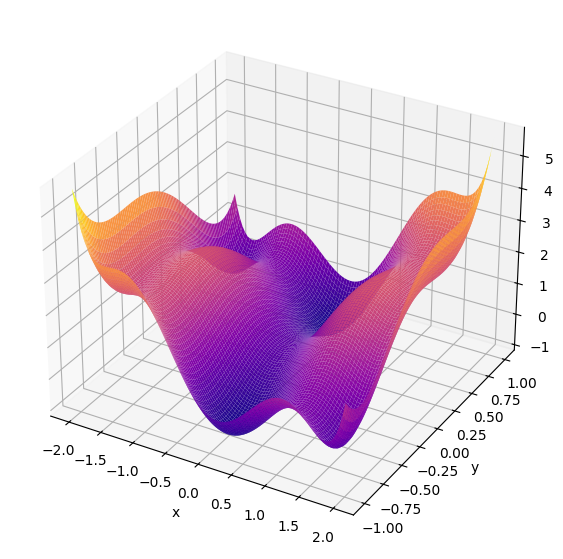

Global minima:  [ 0.08984197 -0.71265635]
Value of f:  -1.0316284534898457
With the initial guess [0,0] the value of the function is 0


In [9]:
def f(x,y):
    return (4 - 2.1*(x**2) + (x**4)/3)*(x**2) + (x*y) + (4*(y**2) - 4)*(y**2)

#variables can be restricted to -2< x <2 and -1< y <1
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)

# 3D print
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, f(X, Y), rstride=1, cstride=1, cmap='plasma', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

init = (1,1)
value_f = optimize.minimize(lambda i: f(i[0], i[1]), init, method='BFGS')
print('Global minima: ', value_f.x)
print('Value of f: ', value_f.fun)
print('With the initial guess [0,0] the value of the function is 0')


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

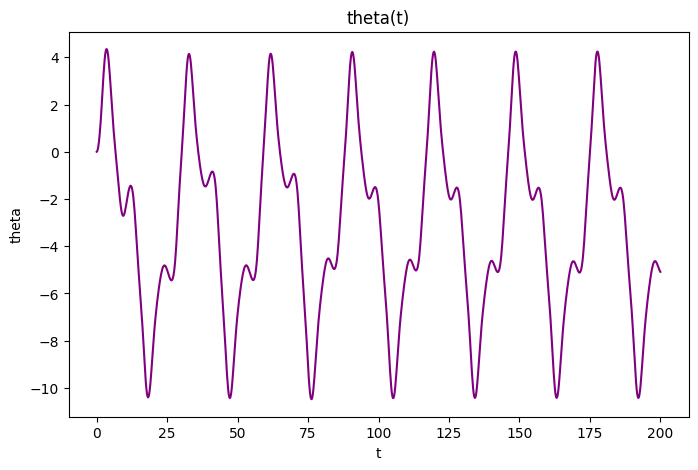

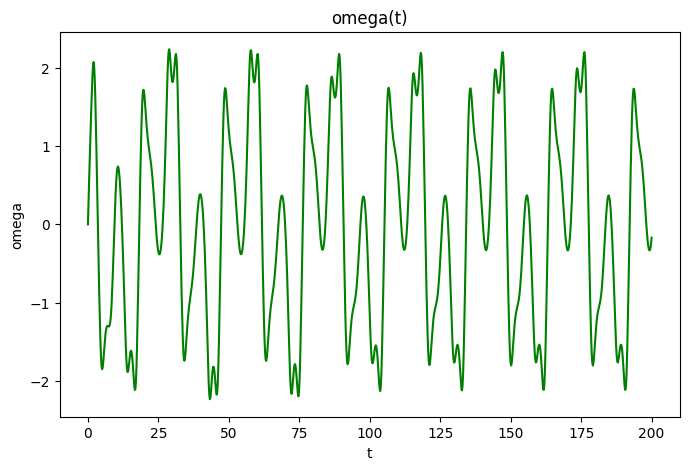

In [10]:
# ODE: damped pendulum
def pendulum(y, t, Q, d, l, g, Ω):
    theta, omega = y
    derivate = [omega, -1/Q*omega + (g/l)*np.sin(theta) + d*np.cos(Ω*t)]
    return derivate

# Initial conditions
y0 = (0, 0) #theta0 and omega
Q = 2.0
d = 1.5
l = 10
g = 9.8
Ω =0.65
t = np.linspace(0, 200, 1000)

sol = odeint(pendulum, y0, t, args=(Q, d, l, g, Ω))

# Plotting the solutions
fig = plt.figure(figsize=(8,5))
plt.plot(t, sol[:, 0], color='purple')
plt.xlabel('t')
plt.ylabel('theta')
plt.title('theta(t)')
plt.show()

fig = plt.figure(figsize=(8,5))
plt.plot(t, sol[:, 1], color='green')
plt.xlabel('t')
plt.ylabel('omega')
plt.title('omega(t)')
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

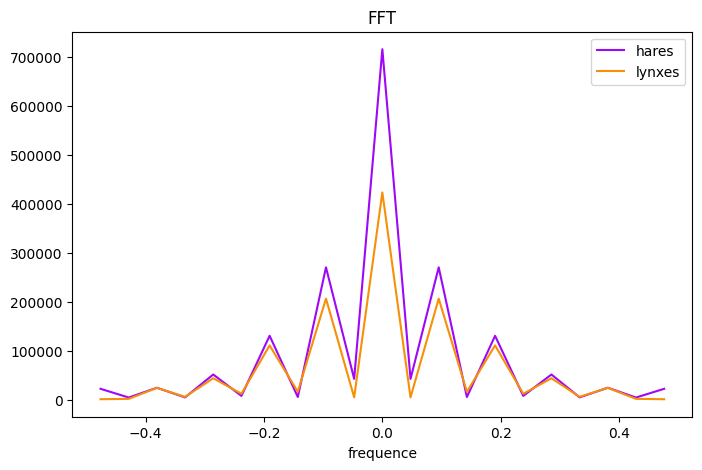

Period of hares:  10.5  years
Period of lynxes:  10.5  years


In [11]:
#load the file
data = np.loadtxt('data/populations.txt')

fft_hares = fft(data.T[1])
fft_lynxes = fft(data.T[2])

hares_freq = fftfreq(len(fft_hares), 1)
lynxes_freq = fftfreq(len(fft_lynxes), 1)

#plot the graphic
plt.figure(figsize=(8,5))
plt.plot(fftpack.fftshift(hares_freq), abs(fftpack.fftshift(fft_hares)), color='#9f07f7', label="hares" )
plt.plot(fftpack.fftshift(lynxes_freq), abs(fftpack.fftshift(fft_lynxes)), color='#f78f07', label="lynxes" )
plt.title('FFT')
plt.xlabel('frequence')
plt.legend()
plt.show()

mask = hares_freq > 0
hfreq = hares_freq[mask]
lfreq = lynxes_freq[mask]
hpowes = np.abs(fft_hares)[mask]
lpowes = np.abs(fft_lynxes)[mask]

# find the max of freqs array
hpeak = hfreq[hpowes.argmax()]
lpeak = lfreq[lpowes.argmax()]

hperiod = 1/hpeak
lperiod = 1/lpeak
print('Period of hares: ', hperiod, ' years')
print('Period of lynxes: ', lperiod, ' years')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

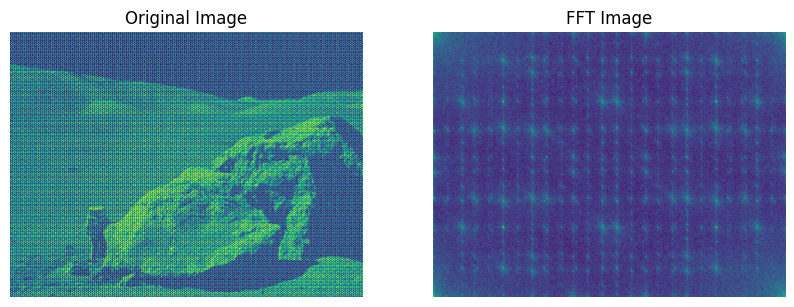

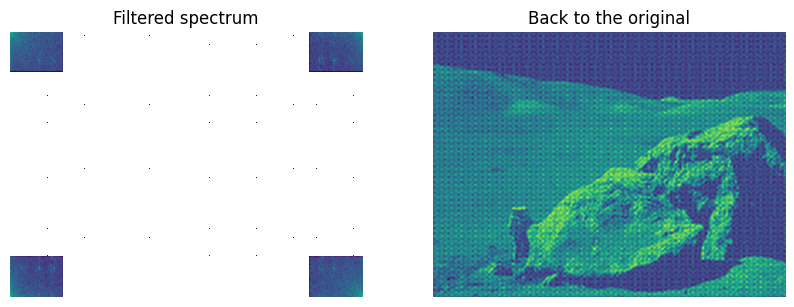

In [12]:
image = plt.imread("images/moonlanding.png")
fftimage = fftpack.fft2(image)

#plot the images
fig, axs = plt.subplots(1, 2,figsize=(10,5))

axs[0].axis('off')
axs[0].set_title('Original Image')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('FFT Image')
axs[1].imshow(abs(fftimage), norm=LogNorm(vmin=5))
plt.show()

fraction = 0.15
high, width = fftimage.shape

#setting the noise regions to zero
fftimage[int(high*fraction):int(high*(1-fraction))] = 0
fftimage[:, int(width*fraction):int(width*(1-fraction))] = 0

#applying the inverse furier transform
ifftimage = fftpack.ifft2(fftimage).real

fig, axs = plt.subplots(1, 2,figsize=(10,5))

axs[0].axis('off')
axs[0].set_title('Filtered spectrum')
axs[0].imshow(abs(fftimage), norm=LogNorm(vmin=5))

axs[1].axis('off')
axs[1].set_title('Back to the original')
axs[1].imshow(ifftimage)
